In [1]:
##### Change to main folder of project, run only once!
import os
os.chdir('../')

In [2]:
from pipeline.service._file import FileService
import polars as pl
from polars import col
import polars.selectors as cs

path = FileService.get_parquet_path("articles_topic")
unfiltered_df = pl.read_parquet(path, )
unfiltered_df.shape

(107624, 22)

In [3]:
unfiltered_df.head(3)

id,pubtime,medium_code,medium_name,doctype,doctype_description,language,char_count,dateline,head,article_link,content_id,content,lead_text,subheadings,author,author_extracted,content_lemmatized,sentiment,score,topics,__index_level_0__
i64,str,str,str,str,str,str,i64,str,str,f64,str,str,str,str,str,null,str,str,f64,list[i64],i64
45083877,"""2022-01-10 00:00:00+01""","""ZWAS""","""20 minutes""","""PRD""","""Regional daily newspaper""","""fr""",894,null,"""20 secondes""",null,"""0000dff0-1d9a-d53a-38c4-8001dd…",""" BOSNIE Les dirigeants de la R…",null,"""Sur fond de sécession""",null,null,""" bosnie dirigeant republika s…","""positive""",0.509,"[59, 34]",0
45700378,"""2022-03-11 00:00:00+01""","""ZWAS""","""20 minutes""","""PRD""","""Regional daily newspaper""","""fr""",2466,null,"""Des drôles de bolides dévoilés…",null,"""0001d2b0-bfea-d40a-32d2-26eef8…",""" Le premier Grand Prix de la s…",""" AUTOMOBILISME Le règlement 20…","""Max Verstappen jusqu’en… 2028""","""LUC DOMENJOZ""",null,""" grand prix saison 2022 dispu…","""positive""",0.517,"[71, 178]",2
42011657,"""2021-02-16 00:00:00+01""","""ZWAS""","""20 minutes""","""PRD""","""Regional daily newspaper""","""fr""",2283,null,"""Des militants détournent des a…",null,"""000262bb-4b91-8eaf-3964-c858cc…",""" Les pratiques antidémocratiqu…",""" VAUD À quelques jours des éle…","""«Respecter la loi»""","""FRÉDÉRIC NEJAD TOULAMI""",null,""" pratique antidémocratique ex…","""positive""",0.512,"[25, 39]",3


In [4]:
unfiltered_df.select(sorted(unfiltered_df.columns)).drop("__index_level_0__").null_count()

article_link,author,author_extracted,char_count,content,content_id,content_lemmatized,dateline,doctype,doctype_description,head,id,language,lead_text,medium_code,medium_name,pubtime,score,sentiment,subheadings,topics
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
107624,85760,107624,0,0,0,0,105500,0,0,0,0,0,73582,0,0,0,0,0,84308,0


In [5]:
df = pl.DataFrame(
        unfiltered_df.with_columns(
            col("topics").list.to_struct().alias("struct_topic"),
        ).select(
            col("id"),
            col("pubtime").alias("date"),
            col("language"),
            col("article_link"),
            col("score").alias("sentiment_score"),
            col("topics").list.to_struct(fields=lambda idx: f"topic{idx}"),
        ).unnest("topics").rows(named=True)
    ).with_columns(
        pl.concat_str(
            [col('^topic.*$')], separator=", ",
        ).alias("topics_string"),
        col("date").str.to_date(format=r"%Y-%m-%d %H:%M:%S", exact=False)
)
df.head(3)

id,date,language,article_link,sentiment_score,topic0,topic1,topics_string
i64,date,str,null,f64,i64,i64,str
45083877,2022-01-10,"""fr""",null,0.509,59,34,"""59, 34"""
45700378,2022-03-11,"""fr""",null,0.517,71,178,"""71, 178"""
42011657,2021-02-16,"""fr""",null,0.512,25,39,"""25, 39"""


<Axes: title={'center': 'Number of articles per topic combination'}, xlabel='Topic combinations, top {max_index}'>

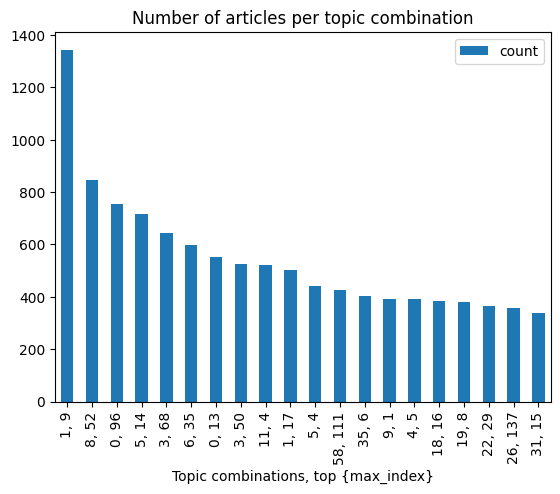

In [6]:
biggest_topic_combination = (
    pl.DataFrame(
        unfiltered_df["topics"].value_counts().with_columns(
            col("topics").list.to_struct().alias("struct_topic")
        ).select(
            col("topics").list.to_struct(fields=lambda idx: f"topic{idx}"),
            col("count")
        ).unnest("topics").rows(named=True)
    ).with_columns(
        pl.concat_str(
            [col('^topic.*$')], separator=", ",
        ).alias("topics_string")
    )
    .sort(by="count", descending=True)
)
max_index = 20
biggest_topic_combination.to_pandas()[:max_index].plot.bar(x="topics_string", y="count", title="Number of articles per topic combination", xlabel="Topic combinations, top {max_index}")

In [7]:
df.group_by(col("language")).len()

language,len
str,u32
"""de""",60297
"""fr""",47327


In [8]:
df["topic0"].value_counts(sort=True).plot.bar(x="topic0", y="count")

alt.Chart(...)

In [9]:
# Count per cluster
df["topic0"].value_counts(sort=True).select("count").describe()

statistic,count
str,f64
"""count""",210.0
"""null_count""",0.0
"""mean""",512.495238
"""std""",582.155254
"""min""",49.0
"""25%""",158.0
"""50%""",317.0
"""75%""",604.0
"""max""",4267.0


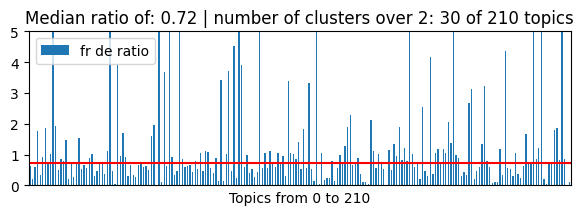

In [10]:
# Find out if the ratio de/fr stays constant within a topic
from matplotlib.pyplot import xlabel

ratio_df = (
    df.group_by(
        col("language"),
        col("topic0")
    )
    .len()
    .pivot("topic0", index="language", values="len")
    .transpose(include_header=True, header_name="topic", column_names="language")
    .with_columns(
        (col("fr") / col("de")).alias("fr de ratio")
    )
).sort(col("topic").cast(pl.Int64)).to_pandas()

median_ratio = ratio_df["fr de ratio"].median()
clusters_over_2_ratio = ratio_df[ratio_df["fr de ratio"] > 2]
n_over_2 = len(clusters_over_2_ratio)
ax = ratio_df.plot.bar(
    x="topic", 
    y="fr de ratio", 
    ylim=(0, 5), 
    title=f"Median ratio of: {round(median_ratio, 2)} | number of clusters over 2: {n_over_2} of {len(ratio_df)} topics",
    figsize=(7,2),
    xlabel=f"Topics from 0 to {len(ratio_df)}",
    xticks=[],)
ax.axhline(median_ratio, c="r", label="median ratio")

In [11]:
# Which topics are most extremely german/french?
top_n = 5
print(f"Top {top_n} german topics:")
print(ratio_df.sort_values("fr de ratio").iloc[:top_n])
print(f"Top {top_n} french topics:")
print(ratio_df.sort_values("fr de ratio", ascending=False).iloc[:top_n])

Top 5 german topics:
    topic   de    fr  fr de ratio
138   138  204   2.0     0.009804
49     49  617  13.0     0.021070
131   131  215   9.0     0.041860
200   200   85   4.0     0.047059
112   112  272  15.0     0.055147
Top 5 french topics:
    topic  de     fr  fr de ratio
195   195   3   91.0    30.333333
54     54  20  549.0    27.450000
81     81  15  384.0    25.600000
111   111  14  275.0    19.642857
58     58  30  515.0    17.166667


<Axes: title={'center': 'Average monthly sentiment over all articles published.\nTwo different models utilized so the rate of change is interesting.'}, xlabel='date'>

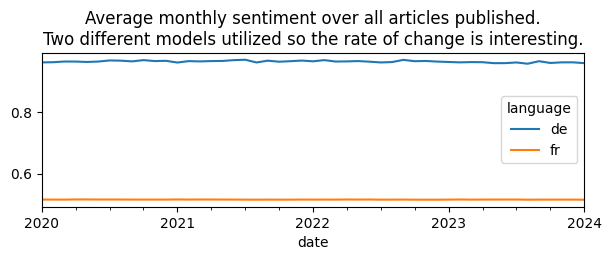

In [12]:
monthly_sentiment = df.group_by(
    col("language"), 
    col("date").dt.round("1mo")
).agg(col("sentiment_score").mean()).to_pandas()

monthly_sentiment.set_index("date", inplace=True)
monthly_sentiment.sort_index(inplace=True)
monthly_sentiment = monthly_sentiment.pivot(columns="language", values="sentiment_score" )
monthly_sentiment.plot(
    title="Average monthly sentiment over all articles published.\nTwo different models utilized so the rate of change is interesting.",
    figsize=(7,2),
)

<Axes: title={'center': 'The monthly sentiment ratio de/fr over all articles'}, xlabel='date'>

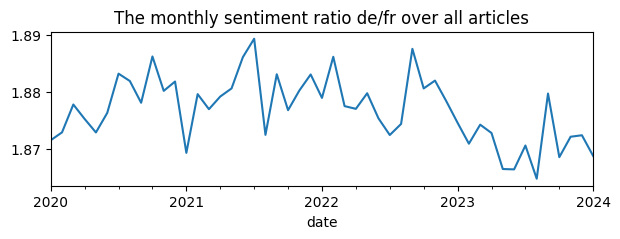

In [13]:
monthly_sentiment["sentiment_ratio"] = monthly_sentiment.de / monthly_sentiment.fr
monthly_sentiment["sentiment_ratio"].plot(
    figsize=(7,2),
    title=f"The monthly sentiment ratio de/fr over all articles"
)
# The magnitude of change over all articles do not significantly change between the german and french versions.

In [14]:
(df.group_by(
        col("language"),
        col("topic0")
        )
    .len()
    .pivot("topic0", index="language", values="len")
)

language,88,27,119,93,153,36,131,198,109,143,39,2,114,57,178,82,116,209,3,23,203,40,145,156,4,60,33,196,87,110,125,43,80,130,152,134,…,172,94,50,54,46,154,92,163,75,26,68,71,148,13,76,175,66,99,158,85,84,19,6,160,53,179,188,207,37,77,61,34,58,128,7,95,101
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""de""",266,610,173,164,110,299,215,15,191,63,461,1624,240,376,72,81,222,44,928,642,30,568,79,116,1809,325,837,50,299,255,150,435,320,203,46,137,…,103,203,104,20,455,122,224,60,370,739,225,324,85,798,209,51,236,252,72,278,198,507,691,71,359,104,50,39,409,89,316,172,30,179,1167,214,156
"""fr""",112,449,97,182,52,509,9,77,100,120,309,990,41,171,42,318,56,5,1641,571,54,192,97,42,596,199,51,43,80,34,100,308,81,24,117,77,…,20,142,525,549,234,38,128,83,59,336,249,130,88,622,215,69,251,78,85,114,195,783,1296,85,230,9,53,33,379,330,195,675,515,64,800,130,164


In [15]:
# Find the average monthly sentiment for every topic
monthly_sentiment_per_topic = (
    df.group_by(
        col("language"), 
        col("topic0"),
        col("date").dt.round("1mo")
    ).agg(col("sentiment_score").mean())
    .sort(by=[col("date"), col("topic0"), col("language")])
    .pivot(on="language", index=["date", "topic0"], values="sentiment_score")
)
monthly_sentiment_per_topic.head(3)

date,topic0,de,fr
date,i64,f64,f64
2020-01-01,0,0.991,0.51825
2020-01-01,1,0.864692,0.512571
2020-01-01,2,0.980417,0.518429


In [16]:
# Fill in missing/empty months by last known value
upsampled_monthly_sentiment_per_topic = (
    monthly_sentiment_per_topic
    .upsample(
        time_column="date",
        every=("1mo"),
        group_by="topic0"
    )
    .sort(by=[col("date"), col("topic0")])
    .fill_null(strategy="forward")
)
upsampled_monthly_sentiment_per_topic.head(3)

date,topic0,de,fr
date,i64,f64,f64
2020-01-01,0,0.991,0.51825
2020-01-01,1,0.864692,0.512571
2020-01-01,2,0.980417,0.518429


In [17]:
monthly_sentiment = upsampled_monthly_sentiment_per_topic.to_pandas()

<Axes: title={'center': 'The monthly sentiment for topic 1'}>

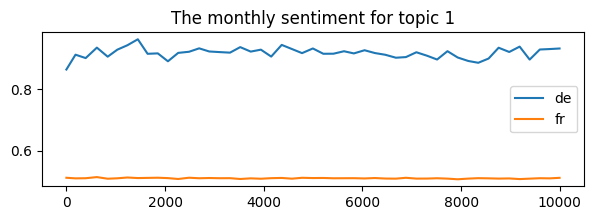

In [18]:
selected_topic = 1
monthly_sentiment.sort_index(inplace=True)
monthly_sentiment[monthly_sentiment.topic0 == selected_topic][["de", "fr"]].plot(
    figsize=(7,2),
    title=f"The monthly sentiment for topic {selected_topic}"
)
# We can see different magnitudes and a shift... so we need to normalize.

In [19]:
# We only use the first 6 Months to fit mean and std, is there a shift in reporting?

monthly_metrics_per_topic = (
    upsampled_monthly_sentiment_per_topic
        .filter(
            col("date")
            .is_between(
                pl.date(2020, 1, 1), 
                pl.date(2020, 6, 30)
            )
        )
        .group_by(col("topic0"), maintain_order=True)
        .agg(
            pl.exclude("date").mean().name.suffix("_mean"),
            pl.exclude("date").std().name.suffix("_std")
        )
)

In [20]:
normalized_monthly_sentiment = (
    upsampled_monthly_sentiment_per_topic
    .join(monthly_metrics_per_topic, on=["topic0"])
    .with_columns(
        ((col("de") - col("de_mean")) / col("de_std")).alias("de_normalized"),
        ((col("fr") - col("fr_mean")) / col("fr_std")).alias("fr_normalized"),
    )
)

In [21]:
# Initialize for next cell for plotting.
i = -1
monthly_sentiment = normalized_monthly_sentiment.to_pandas()
monthly_sentiment.set_index("date", inplace=True)
monthly_sentiment.sort_index(inplace=True)

<Axes: title={'center': 'The monthly sentiment for topic 0'}, xlabel='date'>

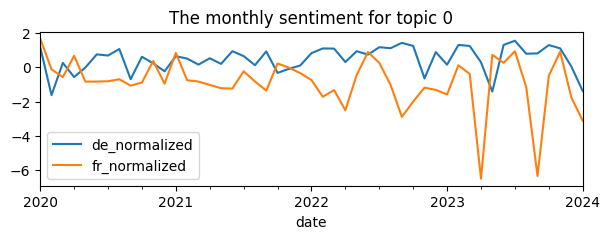

In [22]:
# For each run iterate over the topics
i = i+1
selected_topic = i
monthly_sentiment[monthly_sentiment.topic0 == selected_topic][["de_normalized", "fr_normalized"]].plot(
    figsize=(7,2),
    title=f"The monthly sentiment for topic {selected_topic}"
)

# Topic 12, 14: french sentiment on average lower
# Topic 23: huge dips de, no reaction fr
# Topic 25: fr big variance, some dips below de
# Topic 29: de big variance, some dips below fr 
# Topic 30, 35: fr sentiment slow down trend
# Topic 36: fr slow downtrend, later german downtrend


In [ ]:
# Can we see more with correlation?
topic_sentiment_correlation = (
    normalized_monthly_sentiment
    .group_by(col("topic0"))
    .agg(
        pl.corr("de_normalized", "fr_normalized").alias("correlation")
    ).sort(by="correlation")
)

topic_sentiment_correlation.to_pandas().to_csv("./analysis/topic-sentiment-correlation.csv")

<Axes: title={'center': 'The monthly sentiment for topic 66'}, xlabel='date'>

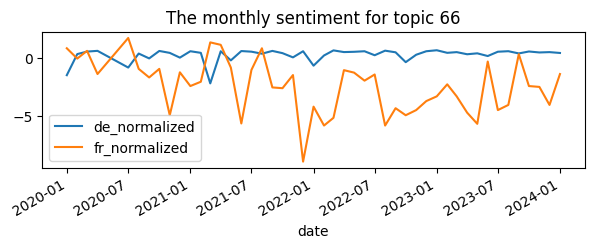

In [24]:
selected_topic = 66
monthly_sentiment[monthly_sentiment.topic0 == selected_topic][["de_normalized", "fr_normalized"]].plot(
    figsize=(7,2),
    title=f"The monthly sentiment for topic {selected_topic}"
)

In [25]:
# We will follow up with 